In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [0]:
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

In [0]:
# data load
path = 'drive/My Drive/bigcontest2019/data/'
# print(os.listdir(path + 'train'),'\n', 
#       os.listdir(path + 'test'),'\n', 
#       os.listdir(path + '../scripts'))

train_label = pd.read_csv(path + 'train/train_label.csv')
train_activity = pd.read_csv(path + 'train/train_activity.csv')
train_payment = pd.read_csv(path + 'train/train_payment.csv')
train_trade = pd.read_csv(path + 'train/train_trade.csv')
train_pledge = pd.read_csv(path + 'train/train_pledge.csv')
train_combat = pd.read_csv(path + 'train/train_combat.csv')



In [0]:
def week_transform(row):
    if row>0 and row<8:
        row = 1
    elif row>7 and row<15:
        row = 2
    elif row>14 and row<22:
        row = 3
    else:
        row = 4
    return row

In [0]:
train_activity['day'] = train_activity['day'].apply(week_transform)
train_payment['day'] = train_payment['day'].apply(week_transform)
train_trade['day'] = train_trade['day'].apply(week_transform)
train_pledge['day'] = train_pledge['day'].apply(week_transform)
train_combat['day'] = train_combat['day'].apply(week_transform)

# activity

In [0]:
# activity
train_activity['game_money_change'] = np.abs(train_activity['game_money_change'])
train_activity_group = train_activity.groupby(['char_id','day']).agg({
                                                             'server':'nunique', 
                                                             'playtime':['sum','mean'], 
                                                             'npc_kill':['sum','mean'], 
                                                             'solo_exp':'sum',
                                                             'party_exp':'sum', 
                                                             'quest_exp':'sum',
                                                             'rich_monster':'sum', 
                                                             'death':'sum', 
                                                             'revive':'sum',
                                                             'exp_recovery':'sum',
                                                             'fishing':'sum',
                                                             'private_shop':'sum',
                                                             'game_money_change':'sum',
                                                             'enchant_count':'sum'}).reset_index(drop=False)

In [0]:
train_activity_group.columns = ['activity_'+'_'.join(x) for x in train_activity_group.columns.ravel()]


In [0]:
(train_activity_group['activity_npc_kill_sum'] == train_activity_group['activity_npc_kill_mean']).value_counts()

True     1513671
False      39672
dtype: int64

In [0]:
(train_activity_group['activity_playtime_sum'] == train_activity_group['activity_playtime_mean']).value_counts()

True     1512648
False      40695
dtype: int64

In [0]:
train_activity_group.columns

Index(['activity_char_id_', 'activity_day_', 'activity_server_nunique',
       'activity_playtime_sum', 'activity_playtime_mean',
       'activity_npc_kill_sum', 'activity_npc_kill_mean',
       'activity_solo_exp_sum', 'activity_party_exp_sum',
       'activity_quest_exp_sum', 'activity_rich_monster_sum',
       'activity_death_sum', 'activity_revive_sum',
       'activity_exp_recovery_sum', 'activity_fishing_sum',
       'activity_private_shop_sum', 'activity_game_money_change_sum',
       'activity_enchant_count_sum'],
      dtype='object')

In [0]:
import sys
mod = sys.modules[__name__]

In [0]:
names = list(train_activity_group.columns)[2:]

for name in names:
    tmp = train_activity_group.pivot(index = 'activity_char_id_',columns='activity_day_',values=name).fillna(0)
    tmp.columns = [name+'_day'+str(x) for x in tmp.columns]

    setattr(mod, '{}'.format(name), tmp)

In [0]:
def merge_by_char_id(df_list):
    '''
    df_list
    '''
    df = eval(df_list[0])

    for arg in df_list[1:]:
        df_arg = eval(arg)
        df = pd.merge(df, df_arg,left_index=True, right_index=True, how='left')

    return df

In [0]:
train_activity_char = merge_by_char_id(names)

In [0]:
train_activity_char.shape

(150960, 448)

# payment

In [0]:
id_label = train_activity.groupby(['acc_id', 'char_id']).agg({'day': 'count'})
id = train_activity.groupby(['acc_id']).agg({'day': 'count'})

In [0]:
label = id_label.div(id, level='acc_id') * 100
label.reset_index(drop=False,inplace=True)
label.rename(columns = {'day':'weight'},inplace=True)

In [0]:
label.head()

,acc_id,char_id,weight
0,2,233598,100.000000
1,5,22260,27.777778
2,5,175813,16.666667
3,5,321231,55.555556
4,8,43437,12.030075


In [0]:
train_payment.sort_values(['acc_id','day'],inplace=True)
train_payment.head(10)

,day,acc_id,amount_spent
11490,1,8,1.056123
11491,26,8,0.348521
35747,10,20,0.035204
35748,12,20,0.035204
35749,21,20,0.826123
62762,17,21,2.346940
62763,26,21,0.348521
2172,7,38,0.442398
2173,12,38,0.586735
2174,23,38,5.280616


In [0]:
weight.head()

,day,acc_id,amount_spent,char_id,weight
0,1,8,1.056123,43437,12.030075
1,1,8,1.056123,71899,7.518797
2,1,8,1.056123,126227,20.300752
3,1,8,1.056123,207949,15.037594
4,1,8,1.056123,257304,21.052632


In [0]:
label

,acc_id,char_id,weight
0,2,233598,100.000000
1,5,22260,27.777778
2,5,175813,16.666667
3,5,321231,55.555556
4,8,43437,12.030075
5,8,71899,7.518797
6,8,126227,20.300752
7,8,207949,15.037594
8,8,257304,21.052632
9,8,305373,10.526316


In [0]:
train_weight = pd.merge(train_payment,label,how='left',on='acc_id')
train_weight['amount_spent'] *= (train_weight['weight']/100)
train_weight.drop(['acc_id','weight'],axis=1,inplace=True)
train_weight.head()

,day,amount_spent,char_id
0,1,0.127052,43437
1,1,0.079408,71899
2,1,0.214401,126227
3,1,0.158816,207949
4,1,0.222342,257304


In [0]:
# payment
train_payment_group = train_weight.groupby(['char_id','day']).agg({'amount_spent':'sum'}).reset_index(drop=False)
train_payment_group.columns = ['payment_'+i for i in train_payment_group.columns]

In [0]:
train_payment_char = train_payment_group.pivot(index = 'payment_char_id',columns='payment_day',values='payment_amount_spent').fillna(0)
train_payment_char.shape

(108378, 28)

# Trade

In [0]:
# trade
## 판매자 테이블 정의
train_trade_seller = train_trade.groupby(['source_char_id','day']).agg({
                                         'type':['nunique','count','sum'], # 거래의 종류들을 파악하기 위해서 -> nuique = 2이면 두 종류의 거래 모두 진행 / count 
                                         'server':'nunique', 
                                         'target_char_id':'nunique',
                                         'item_type':'nunique',
                                         'item_amount':'sum',
                                         'item_price':'sum'}).reset_index(drop=False)

train_trade_seller.columns = ['trade_seller_'+'_'.join(x) for x in train_trade_seller.columns.ravel()]
train_trade_seller['trade_seller_type_count'] -= train_trade_seller['trade_seller_type_sum']
train_trade_seller = train_trade_seller.rename(columns = {'trade_seller_type_count':'trade_seller_type_personal','trade_seller_type_sum':'trade_seller_type_exchange'})



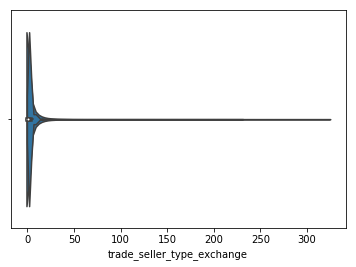

In [0]:
import seaborn as sns
import numpy as np

sns.violinplot(train_trade_seller['trade_seller_type_personal'])
sns.violinplot(train_trade_seller['trade_seller_type_exchange'])


In [0]:

names = list(train_trade_seller.columns)[2:]

for name in names:
    tmp = train_trade_seller.pivot(index = 'trade_seller_source_char_id_',columns='trade_seller_day_',values=name).fillna(0)
    tmp.columns = [name+'_day'+str(x) for x in tmp.columns]

    setattr(mod, '{}'.format(name), tmp)

train_trade_seller_char = merge_by_char_id(names)

In [0]:
def pivoting_df(df):
    ind = list(df.columns)[0]
    col = list(df.columns)[1]
    
    names = list(df.columns)[2:]

    for name in names:
        tmp = df.pivot(index = ind, columns= col,values=name).fillna(0)
        tmp.columns = [name+'_day'+str(x) for x in tmp.columns]

        setattr(mod, '{}'.format(name), tmp)

    final_df = merge_by_char_id(names)
    
    return final_df


In [0]:
train_trade_seller_char.shape

(90413, 224)

In [0]:
## 구매자 테이블 정의
train_trade_buyer = train_trade.groupby(['target_char_id','day']).agg({ 
                                         'type':['nunique','count','sum'], # 거래의 종류들을 파악하기 위해서 -> nuique = 2이면 두 종류의 거래 모두 진행 / count 
                                         'server':'nunique', 
                                         'source_char_id':'nunique', # 몇개의 캐릭터 운용하는지
                                         'item_type':'nunique', 
                                         'item_amount':'sum',
                                          'item_price':'sum'}).reset_index(drop=False)

train_trade_buyer.columns = ['trade_buyer_'+'_'.join(x) for x in train_trade_buyer.columns.ravel()]
train_trade_buyer['trade_buyer_type_count'] -= train_trade_buyer['trade_buyer_type_sum']
train_trade_buyer = train_trade_buyer.rename(columns = {'trade_buyer_type_count':'trade_buyer_type_personal','trade_buyer_type_sum':'trade_buyer_type_exchange'})

In [0]:
names = list(train_trade_buyer.columns)[2:]

for name in names:
    tmp = train_trade_buyer.pivot(index = 'trade_buyer_target_char_id_',columns='trade_buyer_day_',values=name).fillna(0)
    tmp.columns = [name+'_day'+str(x) for x in tmp.columns]

    setattr(mod, '{}'.format(name), tmp)

train_trade_buyer_char = merge_by_char_id(names)

In [0]:
train_trade_buyer_char.shape

(109673, 224)

# pledge



In [0]:
train_pledge.head()

,day,acc_id,char_id,server,pledge_id,play_char_cnt,combat_char_cnt,pledge_combat_cnt,random_attacker_cnt,random_defender_cnt,same_pledge_cnt,temp_cnt,etc_cnt,combat_play_time,non_combat_play_time
0,1,106660,345122,aa,381,0.036089,0.036089,0.0,0.0,0.0,0.0,0.000000,0.007078,0.027568,0.000000
1,1,46383,161773,aa,10892,0.036089,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.006139
2,1,18495,321373,aa,13705,0.036089,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000347
3,1,118293,366707,aa,2982,0.036089,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.001042
4,1,50421,158063,aa,27104,0.216536,0.072179,0.0,0.0,0.0,0.0,0.098883,0.056626,0.083978,0.000000


In [0]:
# pledge
train_pledge_group = train_pledge.groupby(['char_id','day']).agg(
    {
        'server' : 'nunique',               # 캐릭터 서버
        'pledge_id' : 'nunique',            # 혈맹 아이디
        'play_char_cnt' : 'sum',        # 게임에 접속한 혈맹원 수
        'combat_char_cnt' : 'sum',      # 전투에 참여한 혈맹원 수
        'pledge_combat_cnt': 'sum',     # 혈맹 간 전투 횟수의 합
        'random_attacker_cnt' : 'sum',  # 혈맹원 중 막피 전투를 행한 횟수의 합
        'random_defender_cnt': 'sum',   # 혈맹원 중 막피로부터 피해를 받은 횟수의 합
        'same_pledge_cnt': 'sum',       # 동일 혈맹원 간 전투 횟수의 합
        'temp_cnt' : 'sum',             # 혈맹원들의 단발성 전투 횟수의 합
        'etc_cnt' : 'sum',              # 혈맹원들의 기타 전투 횟수의 합
        'combat_play_time': 'sum',      # 혈맹의 전투 캐릭터들의 플레이 시간의 합
        'non_combat_play_time' : 'sum' # 혈맹의 非전투 캐릭터 플레이 시간의 합
    }).reset_index(drop=False)

train_pledge_group.columns = ['pledge_'+x for x in train_pledge_group.columns]


In [0]:
names = list(train_pledge_group.columns)[2:]

for name in names:
    tmp = train_pledge_group.pivot(index = 'pledge_char_id',columns='pledge_day',values=name).fillna(0)
    tmp.columns = [name+'_day'+str(x) for x in tmp.columns]

    setattr(mod, '{}'.format(name), tmp)

train_pledge_char = merge_by_char_id(names)

In [0]:
train_pledge_char.shape

(79158, 336)

# combat

In [0]:
# combat
train_combat_group = train_combat.groupby(['char_id','day']).agg(
    {
        'server' : 'nunique',          # 캐릭터 서버
        'class' : 'nunique',           # 직업
        'pledge_cnt' : 'sum',          # 혈맹간 전투에 참여한 횟수
        'random_attacker_cnt' : 'sum', # 본인이 막피 공격을 행한 횟수
        'random_defender_cnt' : 'sum', # 막피 공격자로부터 공격을 받은 횟수
        'temp_cnt' : 'sum',            # 단발성 전투 횟수
        'same_pledge_cnt' : 'sum',     # 동일 혈맹원 간의 전투 횟수
        'etc_cnt' : 'sum',             # 기타 전투 횟수
        'num_opponent' : 'sum'         # 전투 상대 캐릭터수
    }).reset_index(drop=False)

train_combat_group.columns = ['combat_'+x for x in train_combat_group.columns]


In [0]:
names = list(train_combat_group.columns)[2:]

for name in names:
    tmp = train_combat_group.pivot(index = 'combat_char_id',columns='combat_day',values=name).fillna(0)
    tmp.columns = [name+'_day'+str(x) for x in tmp.columns]

    setattr(mod, '{}'.format(name), tmp)

train_combat_char = merge_by_char_id(names)

In [0]:
train_combat_char.shape

(149247, 252)

# 최종 MERGE
- train_activity_char (150960, 448)
- train_payment_char (108378, 28)
- train_trade_seller_char (90413, 224)
- train_trade_buyer_char (109673, 224)
- train_pledge_char (79158, 336)
- train_combat_char (149247, 252)


각 인덱스가 char_id 값이다!

train_activity를 기준으로, index 기준 merge할 것!!

In [0]:
def merge_final_df(df,*args):
    '''
    df : 기준이 되는 데이터 프레임 (char_id가 전부 있는 쪽으로!!)
    *args : 가변인자 (데이터 프레임을 원하는 만큼 집어넣으면 된다.)
    '''    
    df['char_id'] = list(df.index)
    df.reset_index(drop=True,inplace=True)
    
    for arg in args:
        arg['char_id'] = list(arg.index)
        arg.reset_index(drop=True,inplace=True)
        df = pd.merge(df, arg, how='left',on= 'char_id').fillna(0)
    
    return df

In [0]:
train_char = merge_final_df(train_activity_char ,
                # train_payment_char,
                train_trade_seller_char,
                train_trade_buyer_char ) #,
                # train_pledge_char,
                # train_combat_char)

In [0]:
os.chdir('drive/My Drive/bigcontest2019/scripts/model/BJW/')

In [0]:
train_char.shape

(150960, 897)

In [0]:
train_char.to_csv("train_char_small.csv",encoding='utf-8',index=False)

In [0]:
train_label

,acc_id,survival_time,amount_spent
0,27835,64,0.002559
1,12351,64,0.120154
2,125437,55,0.182593
3,104483,64,0.016241
4,4704,20,0.226396
5,3277,50,0.058863
6,118874,64,0.030777
7,7678,5,0.000000
8,124997,46,0.009187
9,116489,23,0.000000


In [0]:
pd.merge(train_char,train_label,on='char_id'

0              2
1              3
2              5
3              7
4              9
5             13
6             14
7             15
8             17
9             19
10            22
11            23
12            26
13            28
14            29
15            31
16            32
17            34
18            37
19            41
20            46
21            53
22            57
23            59
24            61
25            63
26            64
27            65
28            67
29            70
           ...  
150930    397372
150931    397373
150932    397377
150933    397378
150934    397379
150935    397380
150936    397381
150937    397387
150938    397391
150939    397395
150940    397396
150941    397400
150942    397401
150943    397402
150944    397403
150945    397404
150946    397406
150947    397408
150948    397410
150949    397412
150950    397419
150951    397421
150952    397423
150953    397425
150954    397433
150955    397434
150956    397438
150957    3974

In [0]:
lab = train_activity.groupby(['acc_id','char_id']).agg({'day':'sum'}).reset_index(drop=False)
lab.drop(columns='day',inplace=True)

In [0]:
train_label_char = pd.merge(lab,train_label,on='acc_id',how='left')

In [0]:
os.getcwd()

'/content/drive/My Drive/bigcontest2019/scripts/model/BJW'

In [0]:
# os.chdir('drive/My Drive/bigcontest2019/scripts/model/BJW/Final/')
train_label_char.to_csv('train_label_char.csv',encoding='utf-8',index=False)

In [0]:
from random import randint

six_numbers = []        # 무작위로 뽑힌 6개의 번호를 저장하는 리스트 random_numbers 생성

# 무작위로 정렬된 1 - 45 사이의 숫자 여섯개 뽑기
def generate_numbers():

    for i in range(0, 6):
        new_number = randint(0, 45)
        six_numbers.append(new_number)
    return six_numbers.sort()

# 보너스까지 포함해 7개 숫자 뽑기
# 정렬된 6개의 당첨 번호와 1개의 보너스 번호 리스트를 리턴
# 예: [1, 7, 13, 23, 31, 41, 15]

def draw_winning_numbers():
    generate_numbers()
    bonus_number = randint(1, 45)          # 보너스 번호 추첨
    six_numbers.append(bonus_number)    # 보너스 번호를 기존 6개의 당첨번호 리스트에 추가
    winning_numbers = six_numbers       # 보너스 번호를 추가한 새로운 당첨 번호 리스트 생성
    return winning_numbers

# 두 리스트에서 중복되는 숫자가 몇개인지 구하기
def count_matching_numbers(list1, list2):
    index = 0
    duplicate = 0                   # 중복되는 수의 카운터를 duplicate 라는 변수로 지정
    while index <= len(list2) - 1:
        if list1[index] in list2:
            duplicate = duplicate + 1
        index = index + 1
    return int(duplicate)           # 중복되는 수의 카운터를 숫자형으로 리턴
    # 코드를 입력하세요

# 로또 등수 확인하기
def check(numbers, winning_numbers):
    match = count_matching_numbers(numbers, winning_numbers)
    first_prize = 1000000000
    second_prize = 50000000
    third_prize = 1000000
    fourth_prize = 50000
    last_prize = 5000
    if match == 6:
        return int(first_prize)
    elif match == 5 and winning_numbers[-1] in numbers:
        return int(second_prize)
    elif match == 5:
        return int(third_prize)
    elif match == 4:
        return int(fourth_prize)
    elif match == 3:
        return int(last_prize)